In [1]:
import json
import numpy as np
import pandas as pd
import re

import torch
import torch.nn as nn
import math

from underthesea import word_tokenize

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
json = json.loads(open("data.json",encoding="utf-8").read())

In [4]:
df = pd.json_normalize(json['intents'], record_path='patterns',record_prefix='patterns', meta='tag')
df.head(5)

,patterns0,tag
0,xin chào,greetings
1,hello,greetings
2,alo,greetings
3,himeko,greetings
4,himeko ơi,greetings


In [5]:
stop_words = set()
with open("vietnamese.txt", "r", encoding="utf-8") as file:
    stop_words = set(line.strip() for line in file)
print(len(stop_words))
print(stop_words)

1943
{'lên cao', 'nhỡ ra', 'biết đâu đấy', 'xoẳn', 'à ơi', 'cùng nhau', 'đáng lý', 'thường hay', 'kể như', 'ngày xưa', 'ráo cả', 'từng giờ', 'thuộc bài', 'bản thân', 'do', 'liên quan', 'vài điều', 'chành chạnh', 'ăn chịu', 'nhà khó', 'hiểu', 'ắt thật', 'thật sự', 'đầy', 'thậm từ', 'đang thì', 'tính cách', 'quả là', 'bỗng thấy', 'lời nói', 'ối giời', 'hay làm', 'không có', 'trên dưới', 'ngày ngày', 'khó nghe', 'là vì', 'trong khi', 'đâu nào', 'chung cho', 'cho về', 'đến nơi', 'cơ cùng', 'nghe lại', 'ít lâu', 'xuất kỳ bất ý', 'nói là', 'tấm bản', 'ba', 'cùng cực', 'có chăng là', 'thành thử', 'nghỉm', 'phải', 'ơ kìa', 'lấy xuống', 'bập bõm', 'kể cả', 'như trước', 'tin thêm', 'song le', 'đủ dùng', 'chính giữa', 'nhất định', 'xin', 'ai nấy', 'đang tay', 'không nhận', 'đáng số', 'lấy giống', 'quá trình', 'không biết', 'phải rồi', 'căn tính', 'sao vậy', 'bởi ai', 'toé khói', 'bên cạnh', 'bất tử', 'vấn đề', 'bất cứ', 'chưa chắc', 'chắc lòng', 'gần bên', 'cho tới', 'cơ hội', 'nghĩ ra', 'lấy vào

In [6]:
class TokenizerDataFrame:
    def __init__(self):
        pass
    def preprocess_text(self, text, re_pattern=None, stop_words=None):
        if re_pattern:
            pattern = "[" + re.escape(re_pattern) + "]"
            text = re.sub(pattern, '', text)
        words = word_tokenize(text.lower().strip())
        if stop_words:
            words = [word for word in words if word.lower().strip() not in stop_words]
        return words

    def tokenize_df(self, df, input_column, output_column, re_pattern=None, stop_words=None):
        new_df = df.copy()
        new_df['input'] = df[input_column].apply(lambda x: self.preprocess_text(x, re_pattern, stop_words))
        new_df['output'] = df[output_column].apply(lambda x: self.preprocess_text(x, re_pattern, stop_words))
        new_df.drop(columns=[input_column, output_column], inplace=True)
        return new_df

class IndexDataFrame:
    def __init__(self):
        self.index_dict = {}
        
    def index_df(self, df, input_column, output_column, index_start=0):
        index_dict = {}
        new_df = df.copy()

        for i, row in new_df.iterrows():
            label = row[output_column][0]
            if label not in index_dict:
                index_dict[label] = index_start
                index_start += 1
            if not isinstance(index_dict[label], list):
                new_df.at[i, output_column] = [index_dict[label]]
            else:
                new_df.at[i, output_column] = index_dict[label]

        for i, row in new_df.iterrows():
            indices = []
            for word in row[input_column]:
                if word not in index_dict:
                    index_dict[word] = index_start
                    index_start += 1
                indices.append(index_dict[word])
            new_df.at[i, input_column] = indices

        return new_df, index_dict

    def index_padding_df(self, df, input_column, output_column, index_start=0):
        df_tokenizer_indices, index_dictionary = self.index_df(df, input_column, output_column, index_start)
        max_input_length = df_tokenizer_indices[input_column].apply(len).max()
        max_output_length = df_tokenizer_indices[output_column].apply(len).max()
        df_tokenizer_indices[input_column] = df_tokenizer_indices[input_column].apply(lambda x: x + [0] * (max_input_length - len(x)))
        df_tokenizer_indices[output_column] = df_tokenizer_indices[output_column].apply(lambda x: x + [0] * (max_output_length - len(x)))
        return df_tokenizer_indices, index_dictionary


In [7]:
tokenizer = TokenizerDataFrame()
index = IndexDataFrame()

In [8]:
df_tokenizer = tokenizer.tokenize_df(df, 'patterns0', 'tag', "[.;\]=+-!@#$%^&*()_\[\]?,")
print(f"Dataframe đã được tokenize:\n {df_tokenizer} \n")

Dataframe đã được tokenize:
                                              input       output
0                                      [xin, chào]  [greetings]
1                                          [hello]  [greetings]
2                                            [alo]  [greetings]
3                                         [himeko]  [greetings]
4                                     [himeko, ơi]  [greetings]
..                                             ...          ...
336                  [chuyển, qua, chat, cho, tôi]       [text]
337           [hãy, thử, chuyển, qua, văn bản, đi]       [text]
338                   [chuyển, qua, văn bản, thôi]       [text]
339                   [thử, chuyển, qua, chat, đi]       [text]
340  [hãy, chuyển, qua, chế độ, văn bản, thử, xem]       [text]

[341 rows x 2 columns] 



In [9]:
df_tokenizer_indices,index_dictionary  = index.index_df(df_tokenizer,"input","output",0)
print(f"Từ điển các từ được gán index :\n {index_dictionary} \n")
print(f"Dataframe đã được gán index :\n {df_tokenizer_indices}  \n")

Từ điển các từ được gán index :
 {'greetings': 0, 'goodbye': 1, 'asking': 2, 'search': 3, 'voice': 4, 'text': 5, 'xin': 6, 'chào': 7, 'hello': 8, 'alo': 9, 'himeko': 10, 'ơi': 11, 'khởi động': 12, 'nào': 13, 'thức': 14, 'dậy': 15, 'bạn': 16, 'ngày': 17, 'mới': 18, 'vui': 19, 'đây': 20, 'ở': 21, 'đấy': 22, 'mình': 23, 'bắt đầu': 24, 'rồi': 25, 'nhé': 26, 'hãy': 27, 'cùng': 28, 'làm việc': 29, 'thân mến': 30, 'buổi': 31, 'sáng': 32, 'tươi trẻ': 33, 'vui vẻ': 34, 'sẵn sàng': 35, 'đồng hành': 36, 'thôi': 37, 'đáng': 38, 'yêu': 39, 'chưa': 40, 'thời gian': 41, 'đã': 42, 'à': 43, 'thức giấc': 44, 'ngay': 45, 'xuất hiện': 46, 'đến': 47, 'tạm biệt': 48, 'hẹn': 49, 'gặp': 50, 'lại': 51, 'kết thúc': 52, 'dừng': 53, 'ngưng': 54, 'chương trình': 55, 'stop': 56, 'ngày mai': 57, 'của': 58, 'tôi': 59, 'trở lại': 60, 'biến': 61, 'mất': 62, 'cẩn thận': 63, 'tin': 64, 'nhớ': 65, 'quay': 66, 'thân thương': 67, 'ngọt ngào': 68, 'sớm': 69, 'biết': 70, 'sau': 71, 'trái tim': 72, 'dễ thương': 73, 'giữ': 74, 

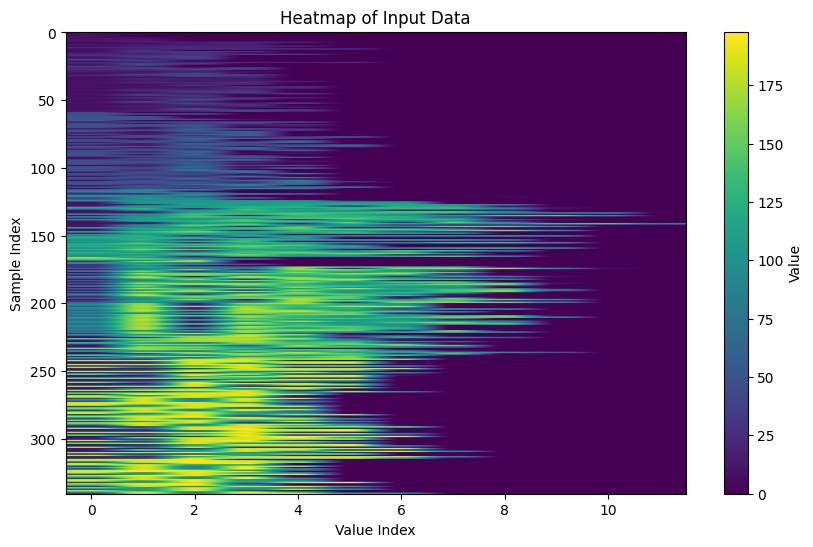

In [10]:
import matplotlib.pyplot as plt

output_counts = df_tokenizer_indices['input'].apply(lambda x: len(x))
input_data = df_tokenizer_indices['input'].tolist()

max_length = max(len(item) for item in input_data)
input_array = np.zeros((len(input_data), max_length))

for i, item in enumerate(input_data):
    input_array[i, :len(item)] = item

plt.figure(figsize=(10, 6))
plt.imshow(input_array, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Heatmap of Input Data')
plt.xlabel('Value Index')
plt.ylabel('Sample Index')
plt.show()

In [11]:
df_tokenizer_indices_padding,index_dictionary  = index.index_padding_df(df_tokenizer,"input","output",1)
print(f"Từ điển các từ được gán index :\n {index_dictionary} \n")
print(f"Dataframe đã được gán index :\n {df_tokenizer_indices_padding}  \n")

Từ điển các từ được gán index :
 {'greetings': 1, 'goodbye': 2, 'asking': 3, 'search': 4, 'voice': 5, 'text': 6, 'xin': 7, 'chào': 8, 'hello': 9, 'alo': 10, 'himeko': 11, 'ơi': 12, 'khởi động': 13, 'nào': 14, 'thức': 15, 'dậy': 16, 'bạn': 17, 'ngày': 18, 'mới': 19, 'vui': 20, 'đây': 21, 'ở': 22, 'đấy': 23, 'mình': 24, 'bắt đầu': 25, 'rồi': 26, 'nhé': 27, 'hãy': 28, 'cùng': 29, 'làm việc': 30, 'thân mến': 31, 'buổi': 32, 'sáng': 33, 'tươi trẻ': 34, 'vui vẻ': 35, 'sẵn sàng': 36, 'đồng hành': 37, 'thôi': 38, 'đáng': 39, 'yêu': 40, 'chưa': 41, 'thời gian': 42, 'đã': 43, 'à': 44, 'thức giấc': 45, 'ngay': 46, 'xuất hiện': 47, 'đến': 48, 'tạm biệt': 49, 'hẹn': 50, 'gặp': 51, 'lại': 52, 'kết thúc': 53, 'dừng': 54, 'ngưng': 55, 'chương trình': 56, 'stop': 57, 'ngày mai': 58, 'của': 59, 'tôi': 60, 'trở lại': 61, 'biến': 62, 'mất': 63, 'cẩn thận': 64, 'tin': 65, 'nhớ': 66, 'quay': 67, 'thân thương': 68, 'ngọt ngào': 69, 'sớm': 70, 'biết': 71, 'sau': 72, 'trái tim': 73, 'dễ thương': 74, 'giữ': 75,

In [12]:
df_tokenizer_indices_padding,index_dictionary  = index.index_padding_df(df_tokenizer,"input","output",1)
print(f"Từ điển các từ được gán index :\n {index_dictionary} \n")
print(f"Dataframe đã được gán index :\n {df_tokenizer_indices_padding}  \n")

Từ điển các từ được gán index :
 {'greetings': 1, 'goodbye': 2, 'asking': 3, 'search': 4, 'voice': 5, 'text': 6, 'xin': 7, 'chào': 8, 'hello': 9, 'alo': 10, 'himeko': 11, 'ơi': 12, 'khởi động': 13, 'nào': 14, 'thức': 15, 'dậy': 16, 'bạn': 17, 'ngày': 18, 'mới': 19, 'vui': 20, 'đây': 21, 'ở': 22, 'đấy': 23, 'mình': 24, 'bắt đầu': 25, 'rồi': 26, 'nhé': 27, 'hãy': 28, 'cùng': 29, 'làm việc': 30, 'thân mến': 31, 'buổi': 32, 'sáng': 33, 'tươi trẻ': 34, 'vui vẻ': 35, 'sẵn sàng': 36, 'đồng hành': 37, 'thôi': 38, 'đáng': 39, 'yêu': 40, 'chưa': 41, 'thời gian': 42, 'đã': 43, 'à': 44, 'thức giấc': 45, 'ngay': 46, 'xuất hiện': 47, 'đến': 48, 'tạm biệt': 49, 'hẹn': 50, 'gặp': 51, 'lại': 52, 'kết thúc': 53, 'dừng': 54, 'ngưng': 55, 'chương trình': 56, 'stop': 57, 'ngày mai': 58, 'của': 59, 'tôi': 60, 'trở lại': 61, 'biến': 62, 'mất': 63, 'cẩn thận': 64, 'tin': 65, 'nhớ': 66, 'quay': 67, 'thân thương': 68, 'ngọt ngào': 69, 'sớm': 70, 'biết': 71, 'sau': 72, 'trái tim': 73, 'dễ thương': 74, 'giữ': 75,

In [13]:
df_tokenizer_indices_padding,index_dictionary  = index.index_padding_df(df_tokenizer,"input","output",1)
print(f"Từ điển các từ được gán index :\n {index_dictionary} \n")
print(f"Dataframe đã được gán index :\n {df_tokenizer_indices_padding}  \n")

Từ điển các từ được gán index :
 {'greetings': 1, 'goodbye': 2, 'asking': 3, 'search': 4, 'voice': 5, 'text': 6, 'xin': 7, 'chào': 8, 'hello': 9, 'alo': 10, 'himeko': 11, 'ơi': 12, 'khởi động': 13, 'nào': 14, 'thức': 15, 'dậy': 16, 'bạn': 17, 'ngày': 18, 'mới': 19, 'vui': 20, 'đây': 21, 'ở': 22, 'đấy': 23, 'mình': 24, 'bắt đầu': 25, 'rồi': 26, 'nhé': 27, 'hãy': 28, 'cùng': 29, 'làm việc': 30, 'thân mến': 31, 'buổi': 32, 'sáng': 33, 'tươi trẻ': 34, 'vui vẻ': 35, 'sẵn sàng': 36, 'đồng hành': 37, 'thôi': 38, 'đáng': 39, 'yêu': 40, 'chưa': 41, 'thời gian': 42, 'đã': 43, 'à': 44, 'thức giấc': 45, 'ngay': 46, 'xuất hiện': 47, 'đến': 48, 'tạm biệt': 49, 'hẹn': 50, 'gặp': 51, 'lại': 52, 'kết thúc': 53, 'dừng': 54, 'ngưng': 55, 'chương trình': 56, 'stop': 57, 'ngày mai': 58, 'của': 59, 'tôi': 60, 'trở lại': 61, 'biến': 62, 'mất': 63, 'cẩn thận': 64, 'tin': 65, 'nhớ': 66, 'quay': 67, 'thân thương': 68, 'ngọt ngào': 69, 'sớm': 70, 'biết': 71, 'sau': 72, 'trái tim': 73, 'dễ thương': 74, 'giữ': 75,

In [14]:
df_tokenizer_indices_padding,index_dictionary  = index.index_padding_df(df_tokenizer,"input","output",1)
print(f"Từ điển các từ được gán index :\n {index_dictionary} \n")
print(f"Dataframe đã được gán index :\n {df_tokenizer_indices_padding}  \n")

Từ điển các từ được gán index :
 {'greetings': 1, 'goodbye': 2, 'asking': 3, 'search': 4, 'voice': 5, 'text': 6, 'xin': 7, 'chào': 8, 'hello': 9, 'alo': 10, 'himeko': 11, 'ơi': 12, 'khởi động': 13, 'nào': 14, 'thức': 15, 'dậy': 16, 'bạn': 17, 'ngày': 18, 'mới': 19, 'vui': 20, 'đây': 21, 'ở': 22, 'đấy': 23, 'mình': 24, 'bắt đầu': 25, 'rồi': 26, 'nhé': 27, 'hãy': 28, 'cùng': 29, 'làm việc': 30, 'thân mến': 31, 'buổi': 32, 'sáng': 33, 'tươi trẻ': 34, 'vui vẻ': 35, 'sẵn sàng': 36, 'đồng hành': 37, 'thôi': 38, 'đáng': 39, 'yêu': 40, 'chưa': 41, 'thời gian': 42, 'đã': 43, 'à': 44, 'thức giấc': 45, 'ngay': 46, 'xuất hiện': 47, 'đến': 48, 'tạm biệt': 49, 'hẹn': 50, 'gặp': 51, 'lại': 52, 'kết thúc': 53, 'dừng': 54, 'ngưng': 55, 'chương trình': 56, 'stop': 57, 'ngày mai': 58, 'của': 59, 'tôi': 60, 'trở lại': 61, 'biến': 62, 'mất': 63, 'cẩn thận': 64, 'tin': 65, 'nhớ': 66, 'quay': 67, 'thân thương': 68, 'ngọt ngào': 69, 'sớm': 70, 'biết': 71, 'sau': 72, 'trái tim': 73, 'dễ thương': 74, 'giữ': 75,

In [15]:
input_tensor = torch.tensor(df_tokenizer_indices_padding['input'].tolist(), dtype=torch.long)
output_tensor = torch.tensor(df_tokenizer_indices_padding['output'].tolist(), dtype=torch.long)

print("Tensor input:")
print(input_tensor)
print("\nTensor output:")
print(output_tensor)

Tensor input:
tensor([[  7,   8,   0,  ...,   0,   0,   0],
        [  9,   0,   0,  ...,   0,   0,   0],
        [ 10,   0,   0,  ...,   0,   0,   0],
        ...,
        [187,  91, 199,  ...,   0,   0,   0],
        [122, 187,  91,  ...,   0,   0,   0],
        [ 28, 187,  91,  ...,   0,   0,   0]])

Tensor output:
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
    

In [16]:
so_gia_tri = np.count_nonzero(input_tensor)
do_dai_toi_da = max(len(row) for row in input_tensor)

combined_list = df_tokenizer_indices_padding['input'].sum() + df_tokenizer_indices_padding['output'].sum()
maxn = max(combined_list) 
unique_values_count = len(set(combined_list))

print(f"Số lượng giá trị trong DataFrame: {unique_values_count}")
print("Độ dài tối đa của một hàng trong tensor là:", do_dai_toi_da)
print("Toàn bộ giá trị số trong tensor là:", so_gia_tri)
print(maxn)

Số lượng giá trị trong DataFrame: 200
Độ dài tối đa của một hàng trong tensor là: 12
Toàn bộ giá trị số trong tensor là: 1925
199


In [17]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, idx):
        input_sample = self.input_tensor[idx]
        output_sample = self.output_tensor[idx]
        return input_sample, output_sample


custom_dataset = CustomDataset(input_tensor, output_tensor)

batch_size = 30
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [18]:
class LayerNormalization(nn.Module):

    def __init__(self, eps:float=10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) 
        self.bias = nn.Parameter(torch.zeros(1)) 

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True) 
        std = x.std(dim = -1, keepdim = True) 
        return self.alpha * (x - mean) / (std + self.eps) + self.bias

class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) 
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) 

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) 

        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0) 
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) 
        return self.dropout(x)

class ResidualConnection(nn.Module):
        def __init__(self, dropout: float) -> None:
            super().__init__()
            self.dropout = nn.Dropout(dropout)
            self.norm = LayerNormalization()
    
        def forward(self, x, sublayer):
            return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model 
        self.h = h 
  
        assert d_model % h == 0, "d_model không chia hết cho đầu attension: h"

        self.d_k = d_model // h 
        self.w_q = nn.Linear(d_model, d_model, bias=False) 
        self.w_k = nn.Linear(d_model, d_model, bias=False) 
        self.w_v = nn.Linear(d_model, d_model, bias=False) 
        self.w_o = nn.Linear(d_model, d_model, bias=False) 
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) 
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) 
        key = self.w_k(k) 
        value = self.w_v(v) 

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)

class EncoderBlock(nn.Module):

    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x
    
class Encoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderBlock(nn.Module):

    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x
    
class Decoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x) -> None:
        return torch.log_softmax(self.proj(x), dim = -1)
    


In [28]:


class TransformerMultiTask(nn.Module):
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, src_seq_len, tgt_seq_len, num_classes, dropout=0.1):
        super(TransformerMultiTask, self).__init__()

        self.src_embedding = InputEmbeddings(d_model, src_vocab_size)
        self.tgt_embedding = InputEmbeddings(d_model, tgt_vocab_size)

        self.src_positional_encoding = PositionalEncoding(d_model, src_seq_len, dropout=dropout)
        self.tgt_positional_encoding = PositionalEncoding(d_model, tgt_seq_len, dropout=dropout)


        self.encoder = nn.ModuleList([EncoderBlock(
            MultiHeadAttentionBlock(d_model, nhead, dropout=dropout),
            FeedForwardBlock(d_model, dim_feedforward, dropout=dropout),
            dropout=dropout
        ) for _ in range(num_encoder_layers)])

        self.decoder = nn.ModuleList([DecoderBlock(
            MultiHeadAttentionBlock(d_model, nhead, dropout=dropout),
            MultiHeadAttentionBlock(d_model, nhead, dropout=dropout),
            FeedForwardBlock(d_model, dim_feedforward, dropout=dropout),
            dropout=dropout
        ) for _ in range(num_decoder_layers)])


        self.classification_projection = nn.Linear(d_model, num_classes)
        self.translation_projection = ProjectionLayer(d_model, tgt_vocab_size)
        
        self.qa_projection = nn.Linear(d_model, 2) 
        self.text_generation_projection = ProjectionLayer(d_model, tgt_vocab_size)

    def forward(self, src_input_ids, tgt_input_ids=None, task = None, padding_value = 0):
        src_embed = self.src_embedding(src_input_ids)
        src_embed = self.src_positional_encoding(src_embed) 
        src_mask = (src_input_ids != padding_value).unsqueeze(1).unsqueeze(2)


        if 'classification' in task or 'translation' in task:
            for encoder_block in self.encoder:
                src_embed = encoder_block(src_embed, src_mask)


        if 'translation' in task or 'text_generation' in task:
            tgt_embed = self.tgt_embedding(tgt_input_ids)
            tgt_embed = self.tgt_positional_encoding(src_embed)
            tgt_mask = (tgt_input_ids != padding_value).unsqueeze(1).unsqueeze(2)
            for decoder_block in self.decoder:
                tgt_embed = decoder_block(tgt_embed, src_embed, src_mask, tgt_mask)

        if 'classification' in task:
            logits = self.classification_projection(src_embed.mean(dim=1))
            return logits

        if 'translation' in task:
            logits = self.translation_projection(tgt_embed)
            return logits

        if 'qa' in task:
            logits = self.qa_projection(tgt_embed)
            return logits

        if 'text_generation' in task:
            logits = self.text_generation_projection(tgt_embed)
            return logits

        raise ValueError("Task not supported.")


In [29]:

import torch.nn as nn
import torch.optim as optim

vocab_size = 200  
tgt_vocab_size = 7
src_vocab_size = 200
d_model = 512  
nhead = 8  
num_encoder_layers = 6  
num_decoder_layers = 6  
dim_feedforward = 2048  
src_seq_len = 12  
tgt_seq_len = 1 
num_classes = 7  
dropout = 0.1  
padding_value = 0
model = TransformerMultiTask(src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, src_seq_len, tgt_seq_len, num_classes, dropout)

classification_criterion = nn.CrossEntropyLoss()
translation_criterion = nn.CrossEntropyLoss()
qa_criterion = nn.CrossEntropyLoss()
text_generation_criterion = nn.CrossEntropyLoss()


classification_optimizer = optim.Adam(model.classification_projection.parameters(), lr=0.001, weight_decay=1e-5)
translation_optimizer = optim.Adam(model.translation_projection.parameters(), lr=0.001)
qa_optimizer = optim.Adam(model.qa_projection.parameters(), lr=0.001)
text_generation_optimizer = optim.Adam(model.text_generation_projection.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score

losses = []
true_labels_list = []
predicted_labels_list = []
accuracy_point = []

num_epochs = 35
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0
    accuracy = 0
    for batch_input, batch_output in dataloader:  
        
        logits = model(batch_input, batch_output, task='classification')

        batch_output = batch_output.view(-1)

        loss = classification_criterion(logits, batch_output)
        
        loss.backward()
        classification_optimizer.step()
        classification_optimizer.zero_grad()
        
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
        true_labels_list.extend(batch_output)
        predicted_labels_list.extend(predicted_labels)

        total_loss += loss.item()
    accuracy = accuracy_score(true_labels_list, predicted_labels_list)
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    accuracy_point.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg Accuracy: {accuracy:.2f}')

print("Huấn luyện hoàn thành!")


Epoch [1/35], Avg Loss: 0.1185, Avg Accuracy: 0.97
Epoch [2/35], Avg Loss: 0.0476, Avg Accuracy: 0.97
Epoch [3/35], Avg Loss: 0.0191, Avg Accuracy: 0.98
Epoch [4/35], Avg Loss: 0.0239, Avg Accuracy: 0.98
Epoch [5/35], Avg Loss: 0.0625, Avg Accuracy: 0.98
Epoch [6/35], Avg Loss: 0.1104, Avg Accuracy: 0.98
Epoch [7/35], Avg Loss: 0.0344, Avg Accuracy: 0.98
Epoch [8/35], Avg Loss: 0.0370, Avg Accuracy: 0.98
Epoch [9/35], Avg Loss: 0.0198, Avg Accuracy: 0.98
Epoch [10/35], Avg Loss: 0.0063, Avg Accuracy: 0.99
Epoch [11/35], Avg Loss: 0.0105, Avg Accuracy: 0.99
Epoch [12/35], Avg Loss: 0.0084, Avg Accuracy: 0.99
Epoch [13/35], Avg Loss: 0.0069, Avg Accuracy: 0.99
Epoch [14/35], Avg Loss: 0.0153, Avg Accuracy: 0.99
Epoch [15/35], Avg Loss: 0.0171, Avg Accuracy: 0.99
Epoch [16/35], Avg Loss: 0.0239, Avg Accuracy: 0.99
Epoch [17/35], Avg Loss: 0.0182, Avg Accuracy: 0.99
Epoch [18/35], Avg Loss: 0.0238, Avg Accuracy: 0.99
Epoch [19/35], Avg Loss: 0.0193, Avg Accuracy: 0.99
Epoch [20/35], Avg Lo

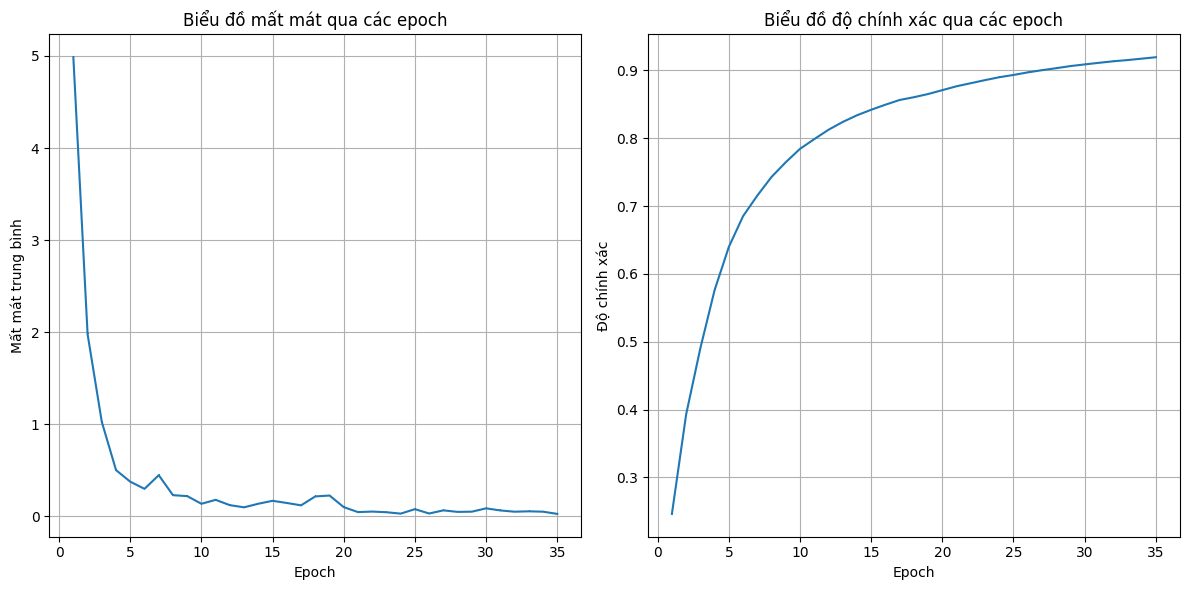

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
plt.plot(range(1, num_epochs + 1), losses, marker=',', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Mất mát trung bình')
plt.title('Biểu đồ mất mát qua các epoch')
plt.grid(True)


plt.subplot(1, 2, 2)  
plt.plot(range(1, num_epochs + 1), accuracy_point, marker=',', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác')
plt.title('Biểu đồ độ chính xác qua các epoch')
plt.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
classification_rep = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.92      0.90      2065
           2       0.90      0.91      0.90      1995
           3       0.90      0.88      0.89      1750
           4       0.95      0.93      0.94      2625
           5       0.94      0.94      0.94      1750
           6       0.94      0.94      0.94      1750

    accuracy                           0.92     11935
   macro avg       0.92      0.92      0.92     11935
weighted avg       0.92      0.92      0.92     11935



In [ ]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    return "Đã lưu model"
save_model_weights(model, 'simple_transformer_weights3.pth')

'Đã lưu model'

In [ ]:
def text_to_index(text, word_dict = index_dictionary):
    pattern= tokenizer.preprocess_text(text)
    index_list = [word_dict[word] for word in pattern if word in word_dict]
    return index_list

In [ ]:
def preprocess_input(text, max_sequence_length=12):
    text_index = torch.tensor(text_to_index(text))
    if len(text_index) < max_sequence_length:

        padded_input_ids = torch.cat([text_index, torch.zeros((max_sequence_length - len(text_index),))])
        processed_input_ids = padded_input_ids.unsqueeze(0)  # Add batch dimension
    elif len(text_index) > max_sequence_length:

        processed_input_ids = text_index[:max_sequence_length].unsqueeze(0)  # Add batch dimension
    else:
        processed_input_ids = text_index.unsqueeze(0)  # Add batch dimension
    
    return processed_input_ids.int() 

text = "khởi động chương trình xin chào"
result = preprocess_input(text)

print(result)

tensor([[13, 56,  7,  8,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)


In [ ]:
import torch


def load_model_weights(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model

def predict(model, result):
    model.eval()  # Chuyển sang chế độ đánh giá

    with torch.no_grad():
        logits = model(result, task='classification')
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    max_probability = torch.max(torch.softmax(logits, dim=1))
    if max_probability < 0.6:
        return 0
    return predicted_labels

loaded_model = TransformerMultiTask(src_vocab_size, tgt_vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, src_seq_len, tgt_seq_len, num_classes, dropout)

model = load_model_weights(loaded_model, 'simple_transformer_weights3.pth')

text = "tôi muốn tìm trang web"
result = preprocess_input(text)
predicted_labels = predict(model,result)

print(predicted_labels)


[4]


In [ ]:
class Solution(object):
    def isPalindrome(self, x = 121):
        """
        :type x: int
        :rtype: bool
        """
        return str(x) == str(x)[::-1]
print(Solution().isPalindrome(121))

True
